## *NECESSARY IMPORTS* #

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import  transforms,datasets 
from torchsummary import summary
import torch.nn.functional as F
from tqdm.auto import tqdm 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## *DATA IMPORTS AND DEFINING THE DATALOADERS* #

In [28]:
data = pd.read_csv('train.csv')
data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# taking a sample of 10000 images only so that training gets faster, just ignoring the sampling
# techiques that all of the classes in the training set must be balanced
data = data.iloc[:10000, 1:].values
train_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)

In [30]:
next(iter(train_loader)).shape

torch.Size([128, 784])

## *DISPLAYING THE IMAGES*

In [31]:
def PlotBatch(data_loader):
  batch = next(iter(data_loader))  # first batch of data_loader
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    temp = batch[i,:]
    plt.imshow(temp.reshape(28,28), cmap='gray')
    plt.axis('off')

In [32]:
def check(batch):
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    temp = batch[i,:]
    plt.imshow(temp.reshape(28,28), cmap='gray')
    plt.axis('off')

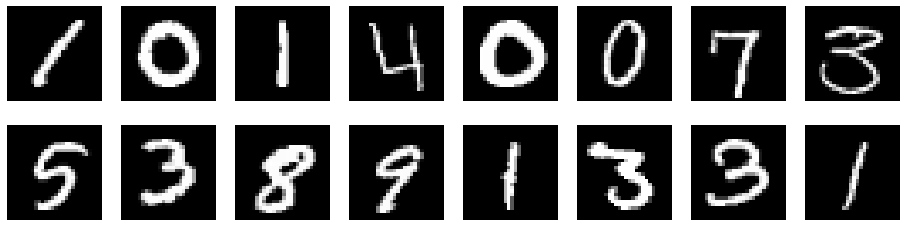

In [33]:
PlotBatch(train_loader)

## *DEFINING THE NETWORKS* 
### * *GENERATOR NETWORK* 
### * *DISCRIMINATOR NETWORK* 

## *GENERATOR NETWORK* #

In [34]:
class gen_net(nn.Module):
    def __init__(self, noise_channels=10, num_channels=64, out_channels=1):
        super(gen_net, self).__init__()
        self.model = nn.Sequential(
            self.gen_block(noise_channels, num_channels, False, 3, 2),
            self.gen_block(num_channels, num_channels*2, False, 4, 1),
            self.gen_block(num_channels*2, num_channels*4, False, 3, 2),
            self.gen_block(num_channels*4, out_channels, True, 4, 2)
        )
    def gen_block(self, in_channels, out_channels, final_layer, kernel_size, stride):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size= kernel_size, stride=stride),    
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size= kernel_size, stride=stride),
                nn.Tanh()
            )
    def forward(self, x):
        # x must be of the shape (noise_channels, 1, 1)
        op = self.model(x)
        return op

In [35]:
gen_net_test = gen_net().to(device)
summary(gen_net_test, input_size=(10,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 3, 3]           5,824
       BatchNorm2d-2             [-1, 64, 3, 3]             128
              ReLU-3             [-1, 64, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         131,200
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7          [-1, 256, 13, 13]         295,168
       BatchNorm2d-8          [-1, 256, 13, 13]             512
              ReLU-9          [-1, 256, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           4,097
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 437,185
Trainable params: 437,185
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## *DISCRIMINATOR NETWORK* 

In [36]:
class disc_net(nn.Module):
    def __init__(self, in_channels=1, num_channels=16, out_channels=1):
        super(disc_net, self).__init__()
        self.model = nn.Sequential(
            self.disc_block(in_channels, num_channels, False),
            self.disc_block(num_channels, num_channels*2, False),
            self.disc_block(num_channels*2, out_channels, True)
        )
        
        
    def disc_block(self, in_channels, out_channels, final_layer, kernel_size=4, stride=2):
        if not final_layer:
            return nn.Sequential( 
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),        
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)       
            )
    def forward(self, x):
        # x must be of the shape (1, 28 ,28)
        op = self.model(x)
        return op

In [37]:
disc_net_test = disc_net().to(device)
summary(disc_net_test, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             272
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]           8,224
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]             513
Total params: 9,105
Trainable params: 9,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.03
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


## *HYPERPARAMETERS, LOSS FUNCTION AND OPTIMIZER*

In [38]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [41]:
lr = 2e-4
batch_size = 128
noise_channels = 10
epochs = 100
beta1, beta2 = 0.5, 0.999  #given in DCGAN experiments
gen = gen_net().to(device)
disc = disc_net().to(device)
gen_optim = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))
disc_optim = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2))
criterion = nn.BCEWithLogitsLoss()

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

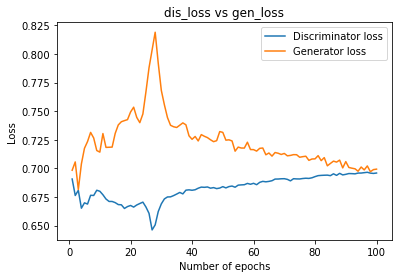

In [50]:
plt.plot(range(1, epochs+1), discriminator_loss, label = "Discriminator loss")
plt.plot(range(1, epochs+1), generator_loss, label = "Generator loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title("dis_loss vs gen_loss")
plt.legend()
plt.show()

### *We can implement WGAN for a much stable training as it does normal GAN suffers from vanishing gradients problem whereas WGAN doesn't (WGAN is more like barrier penalty method.)*